# Task 6 - Project work

### 1 Business Understanding

The objective of this project is to predict the approval or rejection of applications based on historical data. The dataset contains information on multiple variables that could influence the decision-making process, and the goal is to determine how machine learning models can be used to make accurate predictions.

Our main research question is: *Can we build a model that accurately predicts application approval based on available features?* The project applies several machine learning algorithms to achieve this goal.


### 2. Understanding the Data

#### Loading the data and a quick preview
We will load the data sheet and import the required libraries.

First let's take a peak at the data and see what it looks like in its raw form:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Load the dataset
df = pd.read_csv("../Datasets/loan_approval_dataset.csv")


In [2]:
# Display basic information about the dataset
df.info()

# Display the first few rows of the dataset
df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Here we can see the total entries is 4269 which represent invidual loan applications. Also there is a total of 13 columns that represents different features of the loan applicants.

In [3]:
# Drop the 'id' column from the DataFrame
df = df.drop('loan_id' , axis=1)
print(df.columns)

Index([' no_of_dependents', ' education', ' self_employed', ' income_annum',
       ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')


Let's check if there is any null values points.

In [4]:
missing_values = df.isnull().sum()
missing_values

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

As we can see, the data is clean so we can move onwards. Let's start plotting the data.

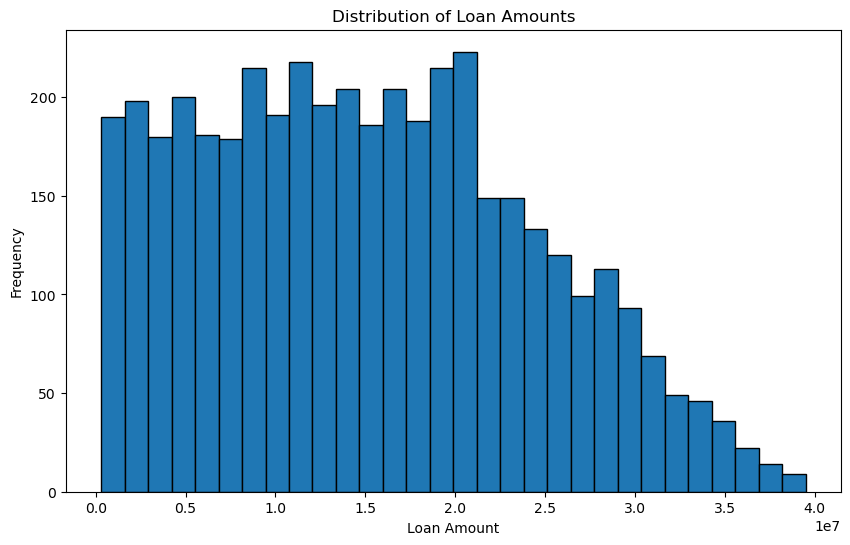

In [5]:
plt.figure(figsize=(10, 6))
df[' loan_amount'].plot(kind='hist', bins=30, edgecolor='black')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amounts')
plt.show()

The results shows us that the loan amounts between 0.3 - 2.0 (millions) are the most frequently applied for. However this isn't exactly the key feature we are looking for, but we can still process this even further to see if this is truly the case by comparing loan amount to the loan status.

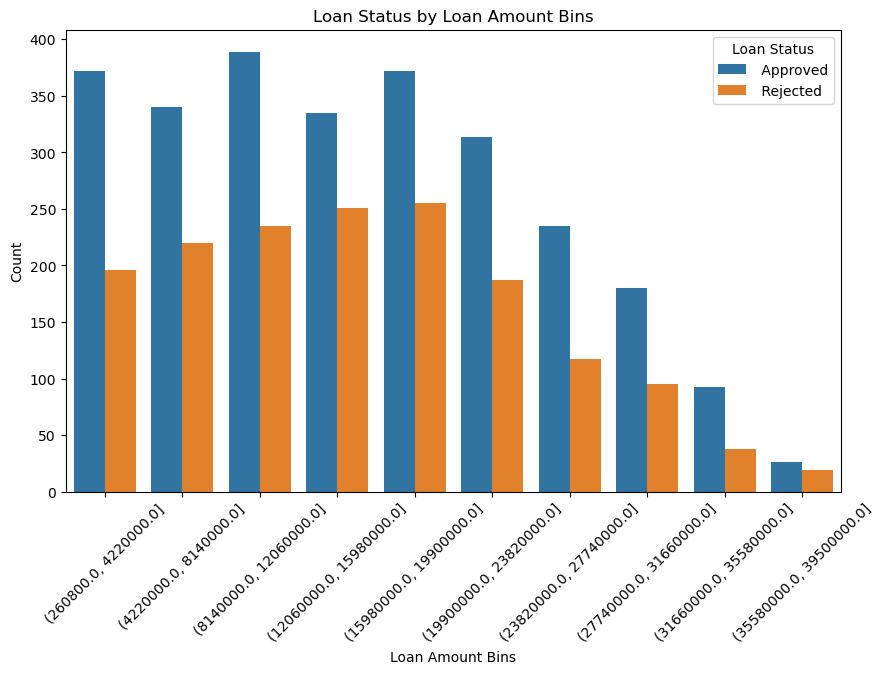

In [6]:
df[' loan_amount_bins'] = pd.cut(df[' loan_amount'], bins=10)


plt.figure(figsize=(10, 6))
sns.countplot(x=' loan_amount_bins', hue=' loan_status', data=df)
plt.title('Loan Status by Loan Amount Bins')
plt.xlabel('Loan Amount Bins')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=45)
plt.show()

The loan amount can be ruled out at this point, since we notice the amount doesn't affect the outcome of loan approval. Moving on to analyze the loan count and see how many how the applications got approved and how many rejected.

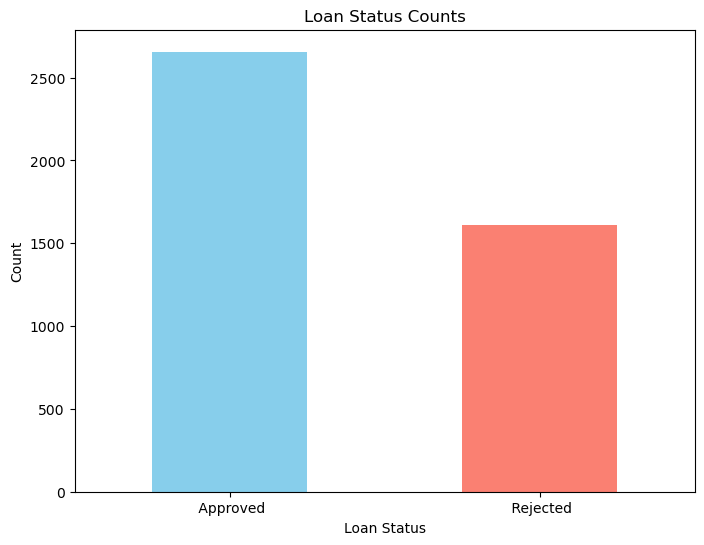

In [7]:

plt.figure(figsize=(8, 6))
df[' loan_status'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Loan Status Counts')
plt.xticks(rotation=0)
plt.show()


Over 50% got approved of the total loan counts. Next up we will plot loan amount compared to the education level.

<Figure size 1000x600 with 0 Axes>

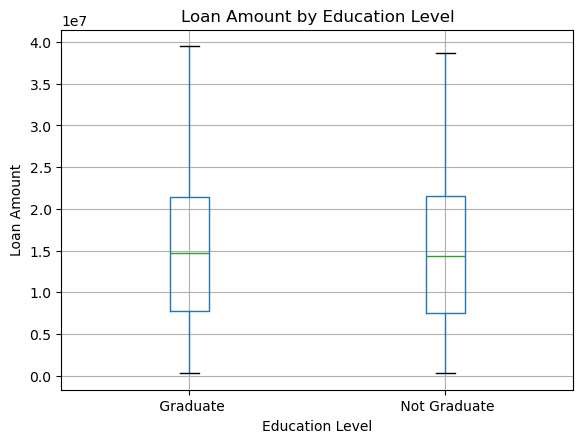

In [8]:
# Create the box plot
plt.figure(figsize=(10, 6))
df.boxplot(column=' loan_amount', by=' education')

# Add labels and title
plt.xlabel('Education Level')
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Education Level')
plt.suptitle('')

# Add grid lines
plt.grid(True, axis='y')

# Display the plot
plt.show()


This boxplot provides a visual representation of how loan amounts are distributed across different educational backgrounds. However there isn't any differences to be noticed. so we will move on with next features.

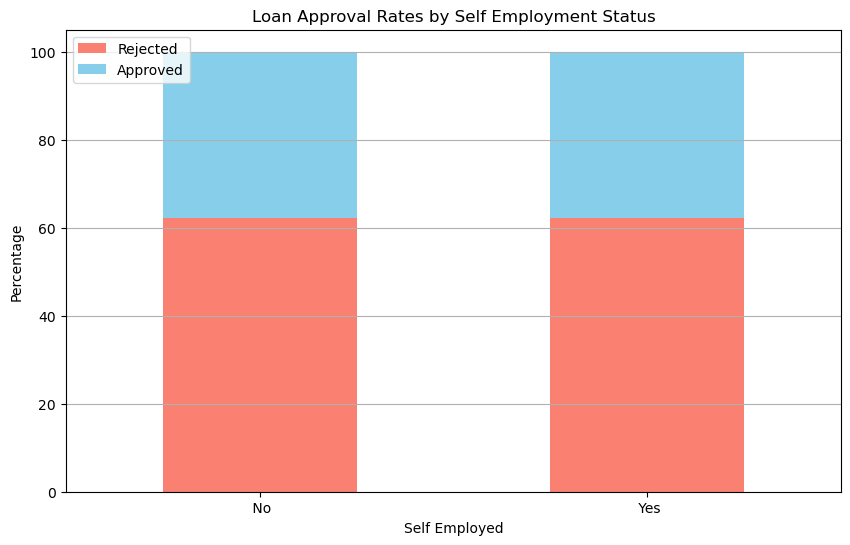

In [9]:
# Calculate loan approval rates by self-employment status
loan_approval_by_self_employed = df.groupby(' self_employed')[' loan_status'].value_counts(normalize=True).unstack() * 100

# Plot the bar chart
loan_approval_by_self_employed.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'skyblue'])

# Add labels and title
plt.xlabel('Self Employed')
plt.ylabel('Percentage')
plt.title('Loan Approval Rates by Self Employment Status')
plt.legend(['Rejected', 'Approved'], loc='upper left')

# Add grid lines
plt.grid(True, axis='y')

# Set x-ticks rotation
plt.xticks(rotation=0)

# Display the plot
plt.show()


A bit over 60% of the overall loan status has been rejected, while only 40% has been approved. This gives us a bit insight of the overall view of the situation.

Next, let's analyze CIBIL Score and it's affection for the Loan Status. We will be using a Strip Plot. Explanation:

Using sns.stripplot: The stripplot function allows for jittering, which helps to spread the points horizontally, preventing overlap and making it clearer how many loans were approved or rejected at each score level.

Dodge and Jitter: The parameters dodge=True and jitter=True help to separate the data points for better visibility. size=6 sets the size of the markers to make them more distinguishable.

Threshold Lines: The vertical lines at CIBIL scores of 550 and 600 remain, visually indicating the significant points in the CIBIL score range.

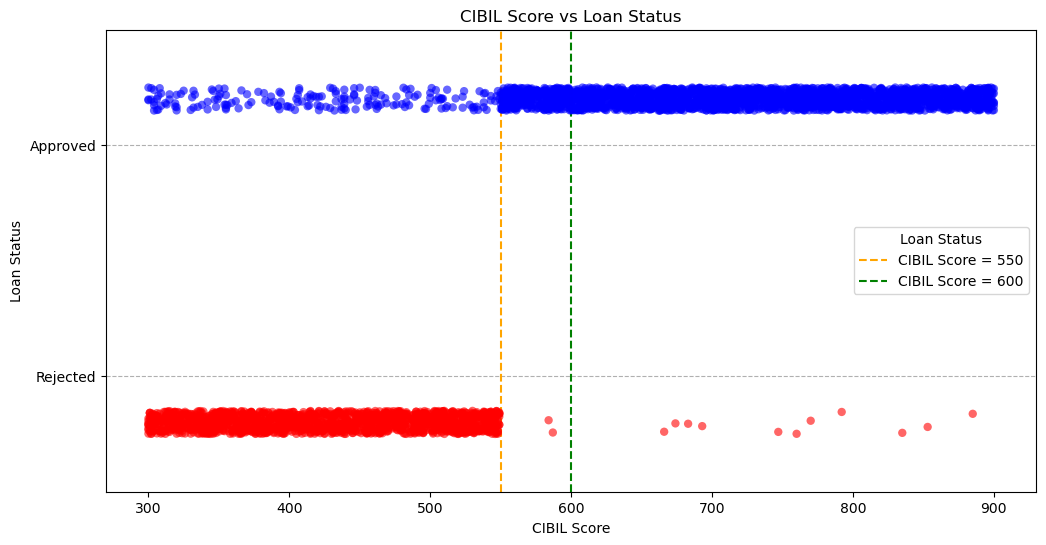

In [10]:
df.columns = df.columns.str.strip()
df['loan_status'] = df['loan_status'].str.strip()


plt.figure(figsize=(12, 6))


sns.stripplot(data=df, x='cibil_score', y='loan_status', hue='loan_status',
               palette={"Approved": "blue", "Rejected": "red"},
               dodge=True, alpha=0.6, jitter=True, marker='o', edgecolor='w', size=6)

plt.axvline(x=550, color='orange', linestyle='--', label='CIBIL Score = 550')
plt.axvline(x=600, color='green', linestyle='--', label='CIBIL Score = 600')


plt.title('CIBIL Score vs Loan Status')
plt.xlabel('CIBIL Score')
plt.ylabel('Loan Status')
plt.legend(title='Loan Status')
plt.grid(axis='y', linestyle='--')
plt.show()


As we can see, clearly the inviduals that seeked for loan with CIBIL Score of under 550 are more common to get Rejected, compared to the ones with CIBIL Score higher than 550. Moving on to prepare the data.

### 3. Data preparation

In [33]:
# Strip leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

# Initialize the label encoder, which creates an instance of the LabelEncoder class, which will be used to convert categorical string labels into numerical labels.
label_encoder = LabelEncoder()

# Encode the categorical variables
df['education'] = label_encoder.fit_transform(df['education'])
df['self_employed'] = label_encoder.fit_transform(df['self_employed'])




Categorical data (like 'education' and 'self_employed') cannot be directly used in many machine learning algorithms, which require numerical input. This conversion allows us to use such variables in predictive modeling.

In the next section, we preprocess the dataset by selecting numerical features, scaling them, and preparing the data for model training and evaluation. These preprocessing steps effectively prepare the dataset for building and evaluating a machine learning model. By scaling the features and splitting the data into training and testing sets, we ensure that the model can learn from a sufficient amount of data while being able to generalize to new, unseen data.

In [34]:
# Select numerical features
numerical_features = ['income_annum', 'loan_amount', 'loan_term', 'cibil_score', 
                      'residential_assets_value', 'commercial_assets_value', 
                      'luxury_assets_value', 'bank_asset_value']

# Initialize the scaler
scaler = StandardScaler()
# Scale the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])
# Define features and target variable
X = df.drop('loan_status', axis=1)
X = X.drop('loan_amount_bins', axis=1)
y = df['loan_status']

print(X.columns)
# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Display the shapes of the datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value'],
      dtype='object')
Training set shape: (3415, 11) (3415,)
Testing set shape: (854, 11) (854,)


These preprocessing steps effectively prepare the dataset for building and evaluating a machine learning model. The training set consists of 3415 samples, which provides a substantial amount of data for the model to learn patterns and relationships within the features. The testing set, containing 854 samples, ensures that we have a robust evaluation of the model's performance on unseen data.

This division indicates a well-balanced dataset, allowing for reliable training while maintaining a sufficient amount of data for validation. A larger training set typically leads to better model performance, as the model can learn from more examples. The shapes of the datasets suggest that the data is well-prepared for further analysis and model training, allowing us to confidently assess how well the model generalizes to new instances.

### 4 Modeling

In [35]:
# Initialize the logistic regression model
model_with_cibil = LogisticRegression(max_iter=1000)

# Train the model with all features
model_with_cibil.fit(X_train, y_train)

# Predict on the test set
y_pred_with_cibil = model_with_cibil.predict(X_test)

In [36]:
# Evaluate the model with CIBIL score
print("Model with CIBIL Score")
print("Accuracy:", accuracy_score(y_test, y_pred_with_cibil))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_with_cibil))
print("Classification Report:\n", classification_report(y_test, y_pred_with_cibil))


Model with CIBIL Score
Accuracy: 0.905152224824356
Confusion Matrix:
 [[498  38]
 [ 43 275]]
Classification Report:
               precision    recall  f1-score   support

    Approved       0.92      0.93      0.92       536
    Rejected       0.88      0.86      0.87       318

    accuracy                           0.91       854
   macro avg       0.90      0.90      0.90       854
weighted avg       0.90      0.91      0.90       854



In [37]:
# Remove the CIBIL score from the features
X_train_no_cibil = X_train.drop('cibil_score', axis=1)
X_test_no_cibil = X_test.drop('cibil_score', axis=1)

# Initialize the logistic regression model
model_without_cibil = LogisticRegression(max_iter=1000)

# Train the model without the CIBIL score
model_without_cibil.fit(X_train_no_cibil, y_train)

# Predict on the test set without CIBIL score
y_pred_without_cibil = model_without_cibil.predict(X_test_no_cibil)


In [38]:
# Evaluate the model without CIBIL score
print("Model without CIBIL Score")
print("Accuracy:", accuracy_score(y_test, y_pred_without_cibil))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_without_cibil))
print("Classification Report:\n", classification_report(y_test, y_pred_without_cibil))


Model without CIBIL Score
Accuracy: 0.6229508196721312
Confusion Matrix:
 [[510  26]
 [296  22]]
Classification Report:
               precision    recall  f1-score   support

    Approved       0.63      0.95      0.76       536
    Rejected       0.46      0.07      0.12       318

    accuracy                           0.62       854
   macro avg       0.55      0.51      0.44       854
weighted avg       0.57      0.62      0.52       854



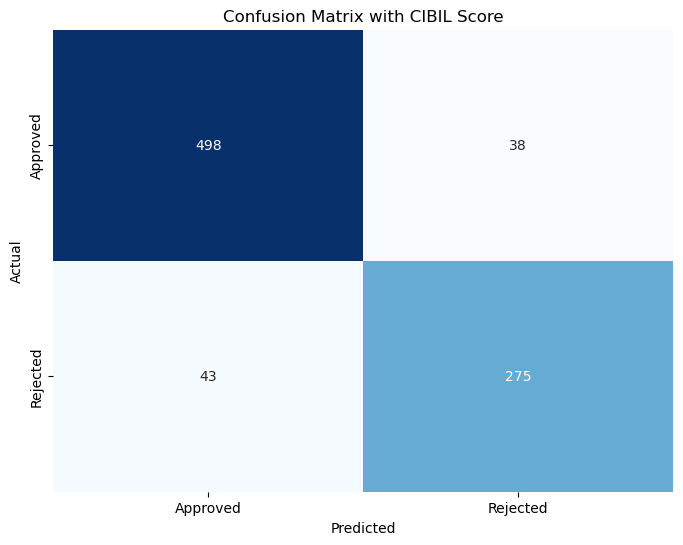

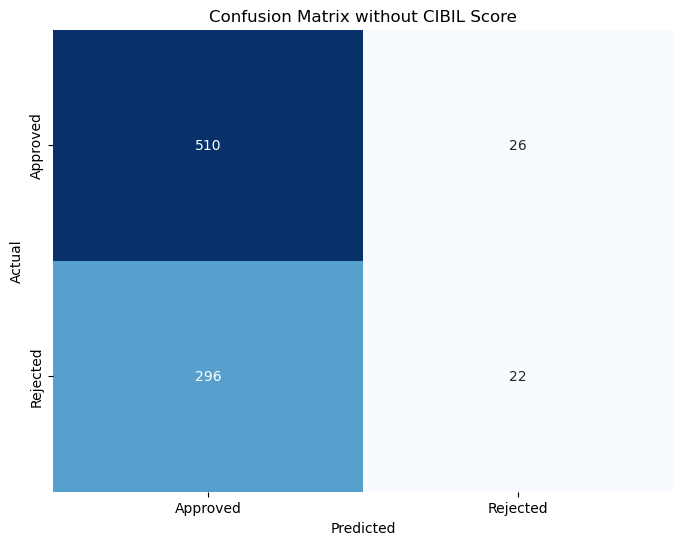

In [39]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=["Approved", "Rejected"], 
                yticklabels=["Approved", "Rejected"])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for both models
plot_confusion_matrix(y_test, y_pred_with_cibil, "Confusion Matrix with CIBIL Score")
plot_confusion_matrix(y_test, y_pred_without_cibil, "Confusion Matrix without CIBIL Score")

In [40]:
from sklearn.inspection import permutation_importance


# Compute Permutation Importance for both models
perm_importance_with_cibil = permutation_importance(model_with_cibil, X_test, y_test, n_repeats=30, random_state=42)
perm_importance_without_cibil = permutation_importance(model_without_cibil, X_test_no_cibil, y_test, n_repeats=30, random_state=42)

# Ensure the 'Feature' column aligns with the features used in both models
features_with_cibil = X_test.columns
features_without_cibil = X_test_no_cibil.columns



perm_importance_df = pd.DataFrame({
    'Feature': features_with_cibil,  # This should align with the features used for model_with_cibil
    'Importance with CIBIL': perm_importance_with_cibil.importances_mean,
    'Importance without CIBIL': np.append(perm_importance_without_cibil.importances_mean, [np.nan])  # Align lengths by appending NaN
})


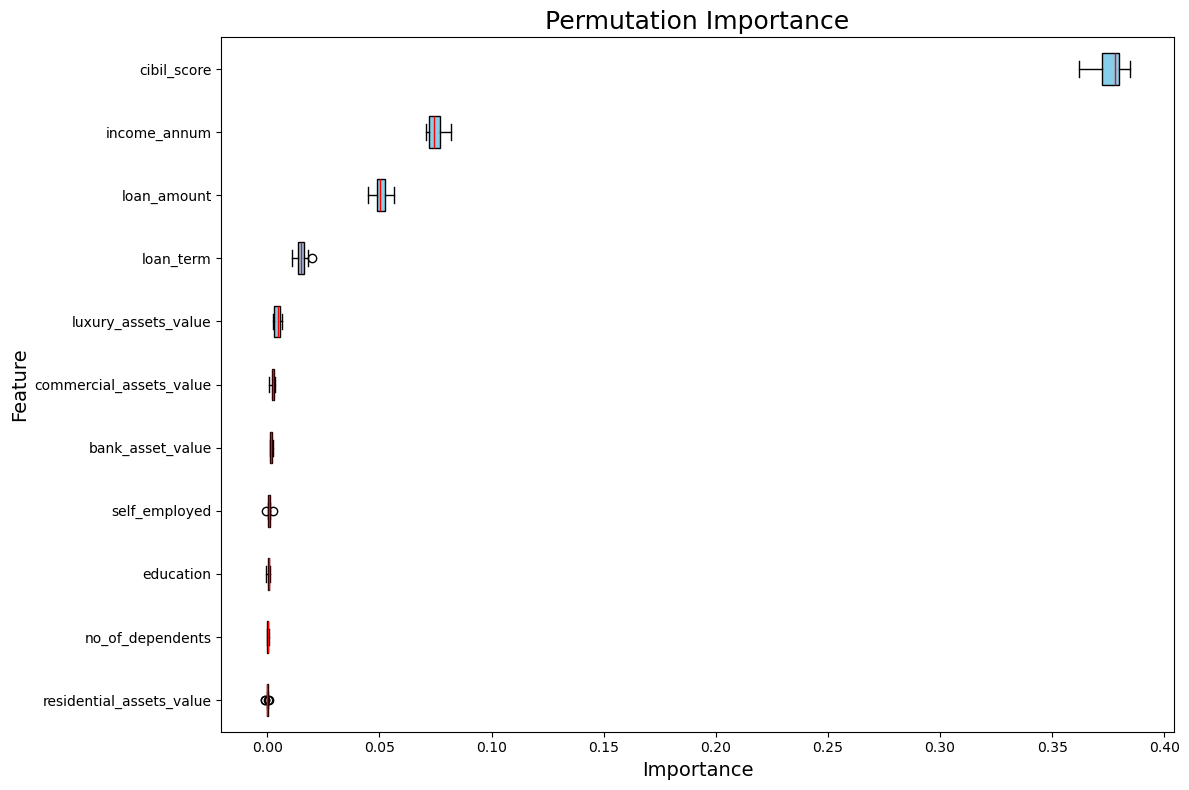

In [127]:
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train, y_train)

# Compute permutation importance
result = permutation_importance(reg, X, y, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Increase the figure size for better readability

# Boxplot for permutation importance
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx], patch_artist=True,
           boxprops=dict(facecolor='skyblue', color='black'), 
           medianprops=dict(color='red'), 
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'))

# Set plot titles and labels
ax.set_title("Permutation Importance", fontsize=18)
ax.set_xlabel("Importance", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()

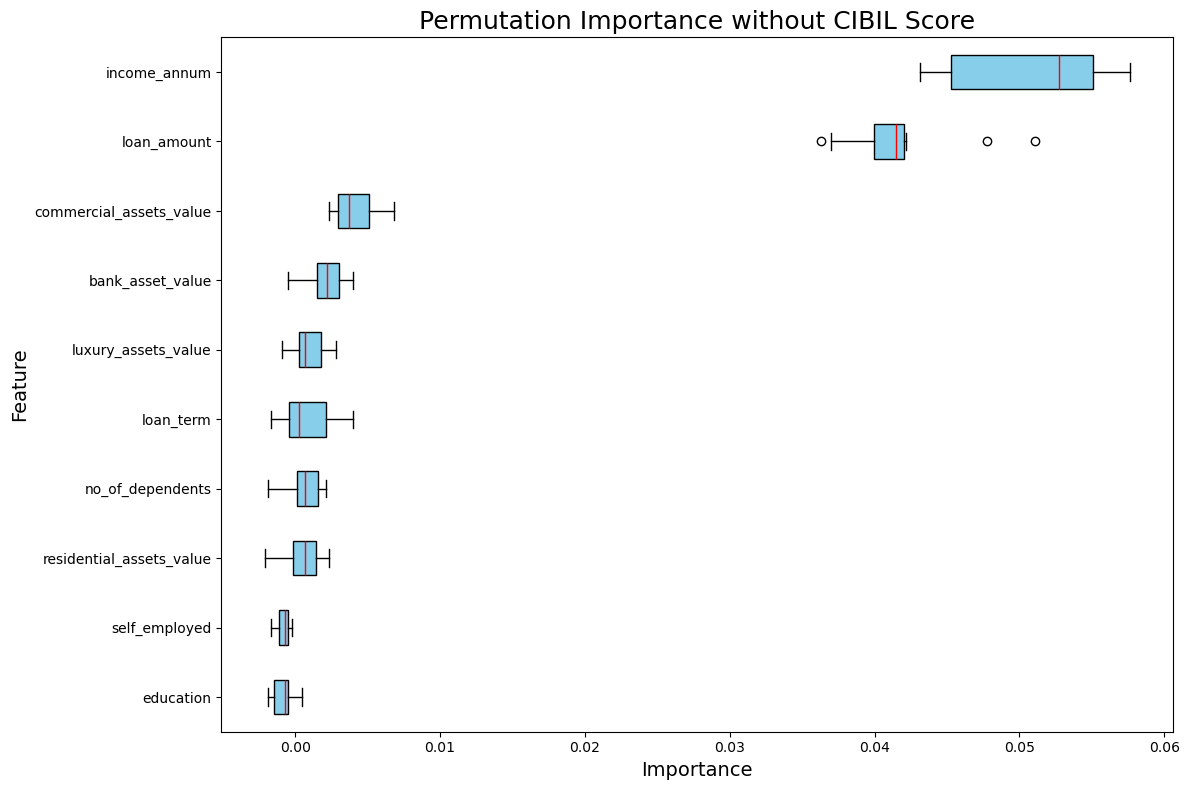

In [128]:
reg_without_cibil = LogisticRegression(max_iter=1000)
reg_without_cibil.fit(X_train_no_cibil, y_train)

# Compute permutation importance without CIBIL score
result_no_cibil = permutation_importance(reg_without_cibil, X_no_cibil, y, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)
sorted_idx_no_cibil = result_no_cibil.importances_mean.argsort()

# Create the figure and axis
fig_no_cibil, ax_no_cibil = plt.subplots(figsize=(12, 8))  # Increase the figure size for better readability

# Boxplot for permutation importance without CIBIL score
ax_no_cibil.boxplot(result_no_cibil.importances[sorted_idx_no_cibil].T, vert=False, 
                     labels=X_no_cibil.columns[sorted_idx_no_cibil], 
                     patch_artist=True,
                     boxprops=dict(facecolor='skyblue', color='black'), 
                     medianprops=dict(color='red'), 
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'))

# Set plot titles and labels
ax_no_cibil.set_title("Permutation Importance without CIBIL Score", fontsize=18)
ax_no_cibil.set_xlabel("Importance", fontsize=14)
ax_no_cibil.set_ylabel("Feature", fontsize=14)

# Adjust layout
fig_no_cibil.tight_layout()
plt.show()


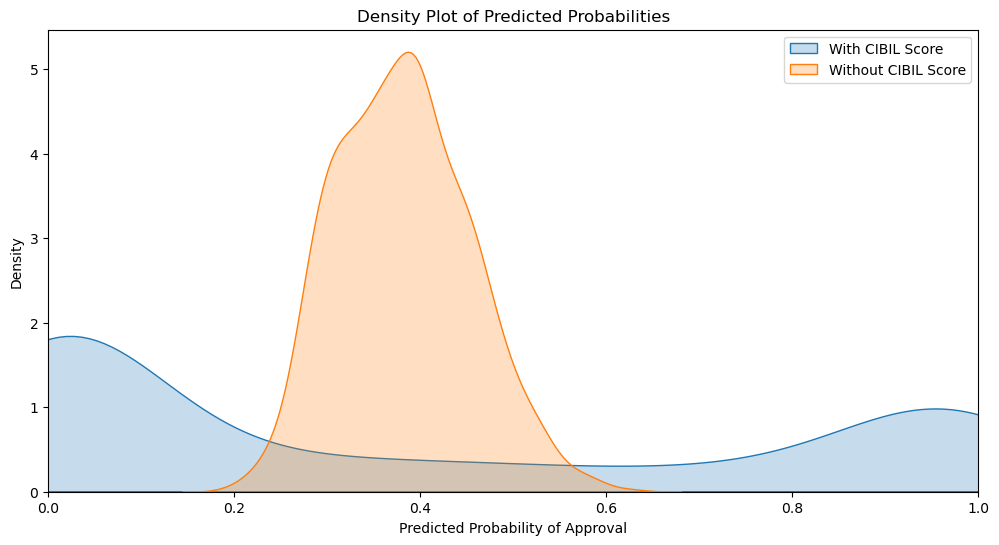

In [73]:
# Predict probabilities for both models
probs_with_cibil = model_with_cibil.predict_proba(X_test)[:, 1]  # Probability of approval
probs_without_cibil = model_without_cibil.predict_proba(X_test_no_cibil)[:, 1]

# Create DataFrame for predicted probabilities
pred_probs_df = pd.DataFrame({
    'Probability with CIBIL Score': probs_with_cibil,
    'Probability without CIBIL Score': probs_without_cibil
})

pred_probs_df = pred_probs_df[(pred_probs_df['Probability with CIBIL Score'] >= 0) & 
                               (pred_probs_df['Probability with CIBIL Score'] <= 1) & 
                               (pred_probs_df['Probability without CIBIL Score'] >= 0) & 
                               (pred_probs_df['Probability without CIBIL Score'] <= 1)]

# Plot the predicted probabilities after filtering
plt.figure(figsize=(12, 6))
sns.kdeplot(pred_probs_df['Probability with CIBIL Score'], label='With CIBIL Score', fill=True)
sns.kdeplot(pred_probs_df['Probability without CIBIL Score'], label='Without CIBIL Score', fill=True)
plt.title('Density Plot of Predicted Probabilities')
plt.xlabel('Predicted Probability of Approval')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1)  # Limit the x-axis to valid probability range
plt.show()


With CIBIL Score (Blue Line):

The density is relatively standard or narrow, showing that most predicted probabilities are concentrated in a specific range. This suggests that the model is consistent in its predictions when the CIBIL score is included.
There seems to be a peak around 0.4, indicating that a significant number of loan applications are predicted to have a 40% chance of approval, with fewer applications predicted to be closer to 0 or 1.
Without CIBIL Score 

(Orange Line):

The density is much wider and has a different shape, indicating more variability in the predicted probabilities. This suggests that the model makes less consistent predictions without the CIBIL score.
The large peak indicates that there is a significant number of predictions clustering at the lower probability ranges (around 0.2-0.4) and a tail extending toward the higher probabilities, but fewer predictions at those extremes compared to when the CIBIL score is included.

In [44]:
# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Fit the model to the training data
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3, random_state=42)

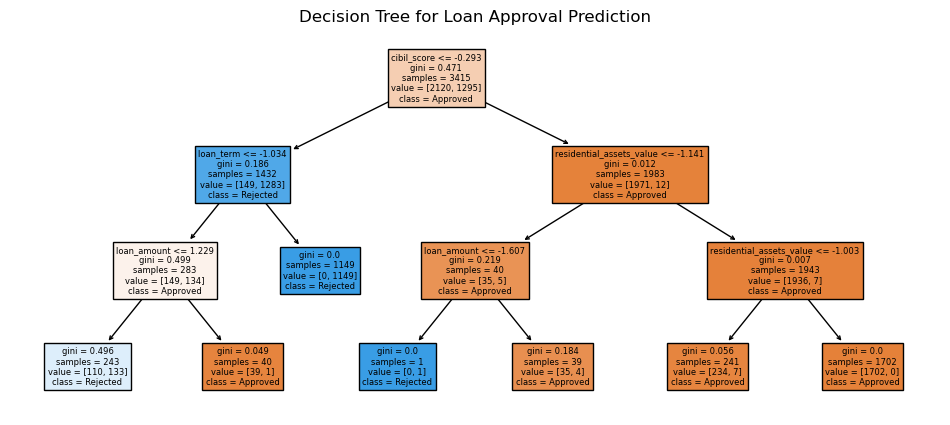

In [45]:
# Plot the decision tree
plt.figure(figsize=(12, 5))
plot_tree(dt_model, feature_names=X_train.columns, class_names=['Approved', 'Rejected'], filled=True)
plt.title("Decision Tree for Loan Approval Prediction")
plt.show()


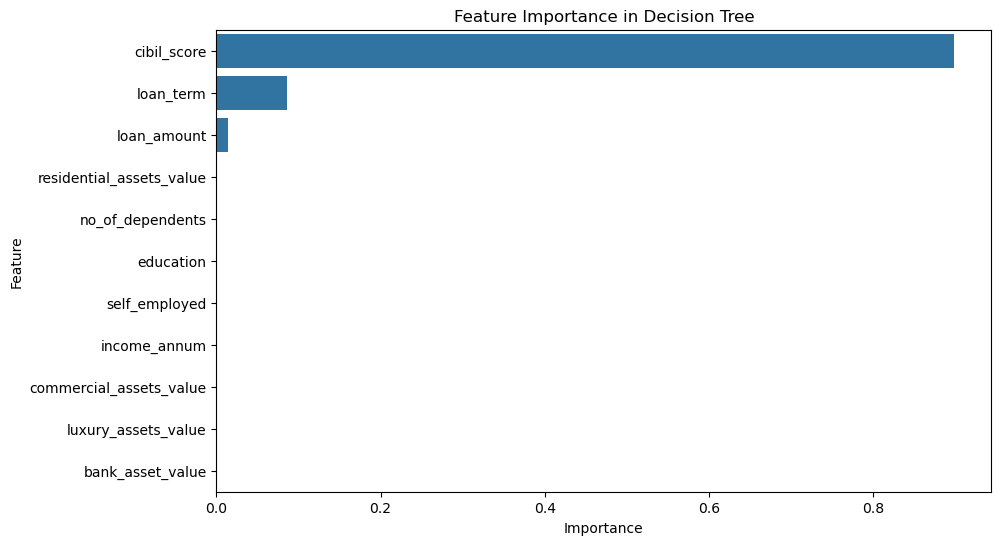

In [46]:
# Get feature importances
importances = dt_model.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [47]:
# Make predictions
y_pred_pruned = dt_model.predict(X_test)

# Evaluate the pruned model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pruned))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_pruned))


Confusion Matrix:
[[508  28]
 [  3 315]]

Classification Report:
              precision    recall  f1-score   support

    Approved       0.99      0.95      0.97       536
    Rejected       0.92      0.99      0.95       318

    accuracy                           0.96       854
   macro avg       0.96      0.97      0.96       854
weighted avg       0.97      0.96      0.96       854



In [48]:
# Generate predictions for both models
y_pred_logistic = model_with_cibil.predict(X_test)
y_pred_pruned = dt_model.predict(X_test)


In [49]:
# Confusion Matrix for Logistic Regression
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
print("Confusion Matrix for Logistic Regression:")
print(cm_logistic)

# Confusion Matrix for Pruned Decision Tree
cm_pruned = confusion_matrix(y_test, y_pred_pruned)
print("\nConfusion Matrix for Pruned Decision Tree:")
print(cm_pruned)

Confusion Matrix for Logistic Regression:
[[498  38]
 [ 43 275]]

Confusion Matrix for Pruned Decision Tree:
[[508  28]
 [  3 315]]


In [50]:
# Classification Report for Logistic Regression
report_logistic = classification_report(y_test, y_pred_logistic)
print("\nClassification Report for Logistic Regression:")
print(report_logistic)

# Classification Report for Pruned Decision Tree
report_pruned = classification_report(y_test, y_pred_pruned)
print("\nClassification Report for Pruned Decision Tree:")
print(report_pruned)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Approved       0.92      0.93      0.92       536
    Rejected       0.88      0.86      0.87       318

    accuracy                           0.91       854
   macro avg       0.90      0.90      0.90       854
weighted avg       0.90      0.91      0.90       854


Classification Report for Pruned Decision Tree:
              precision    recall  f1-score   support

    Approved       0.99      0.95      0.97       536
    Rejected       0.92      0.99      0.95       318

    accuracy                           0.96       854
   macro avg       0.96      0.97      0.96       854
weighted avg       0.97      0.96      0.96       854



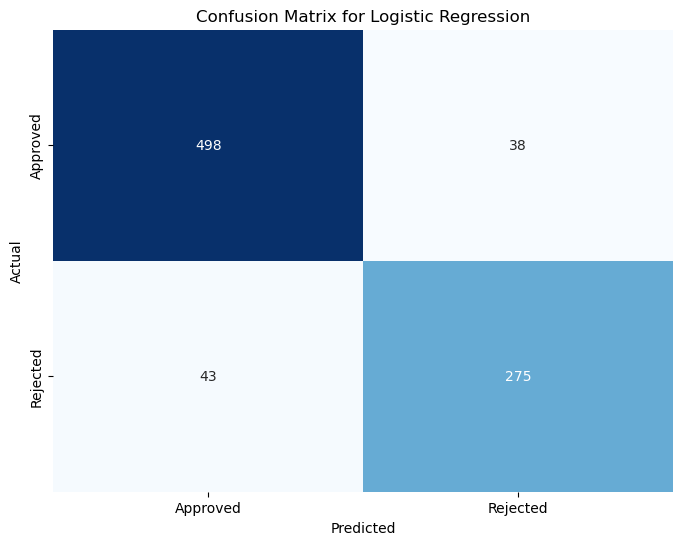

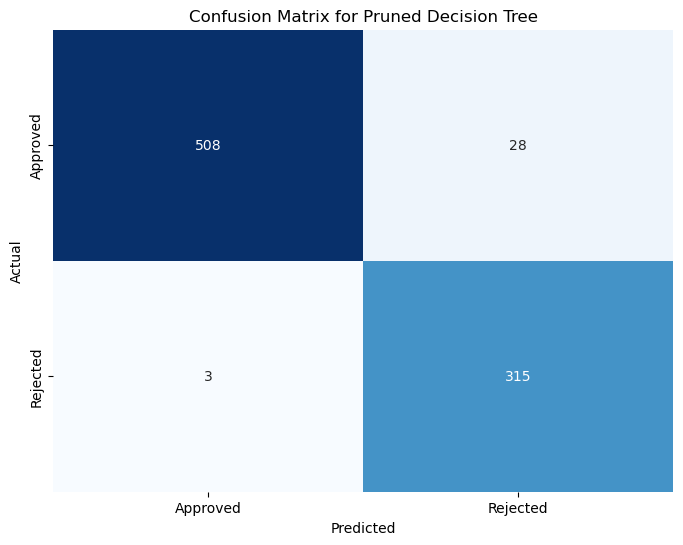

In [51]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Approved', 'Rejected'], 
                yticklabels=['Approved', 'Rejected'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(cm_logistic, 'Logistic Regression')
plot_confusion_matrix(cm_pruned, 'Pruned Decision Tree')

Decision Tree without CIBIL Score
Accuracy: 0.6264637002341921
Confusion Matrix:
 [[530   6]
 [313   5]]
Classification Report:
               precision    recall  f1-score   support

    Approved       0.63      0.99      0.77       536
    Rejected       0.45      0.02      0.03       318

    accuracy                           0.63       854
   macro avg       0.54      0.50      0.40       854
weighted avg       0.56      0.63      0.49       854



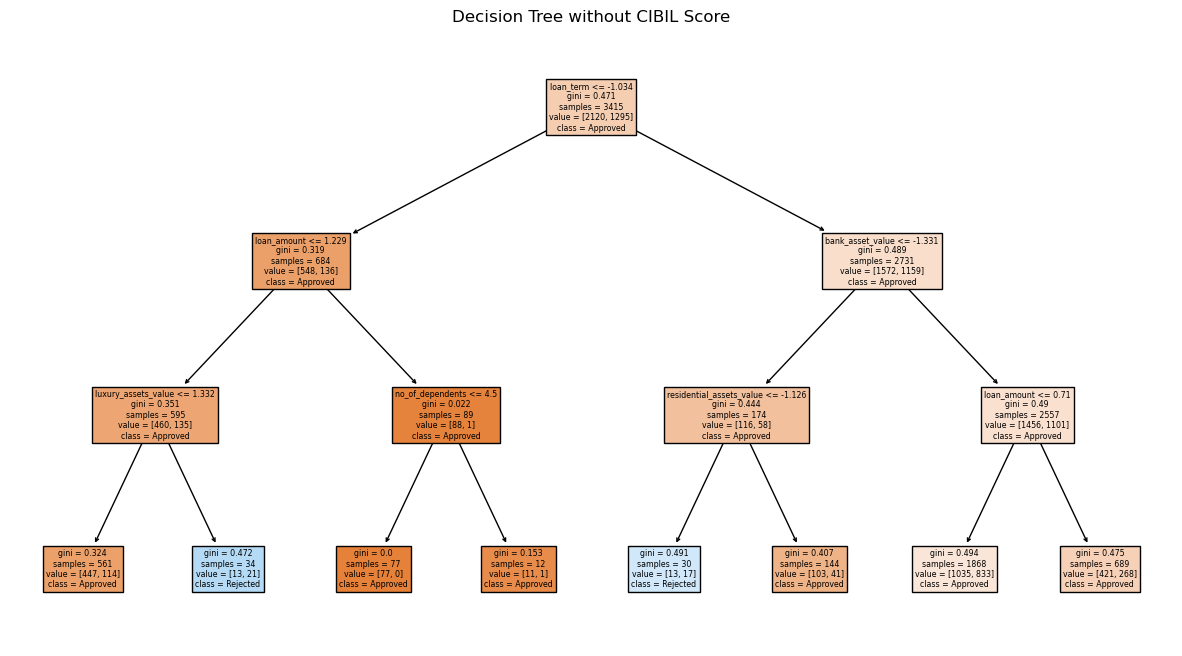

In [62]:
# Select features without 'cibil_score'
X_no_cibil = df.drop(['cibil_score'], axis=1)
X_no_cibil = X_no_cibil.drop('loan_status', axis=1)
X_no_cibil = X_no_cibil.drop('loan_amount_bins', axis=1)
y = df['loan_status']

# Split the data: 80% training, 20% testing
X_train_no_cibil, X_test_no_cibil, y_train, y_test = train_test_split(X_no_cibil, y, test_size=0.2, random_state=42)

# Initialize the decision tree classifier
dt_classifier = DecisionTreeClassifier(max_depth=3,random_state=42)

# Train the model without the CIBIL score
dt_classifier.fit(X_train_no_cibil, y_train)

# Predict on the test set without CIBIL score
y_pred_no_cibil = dt_classifier.predict(X_test_no_cibil)

# Evaluate the model without CIBIL score
print("Decision Tree without CIBIL Score")
print("Accuracy:", accuracy_score(y_test, y_pred_no_cibil))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_no_cibil))
print("Classification Report:\n", classification_report(y_test, y_pred_no_cibil))

# Plot the decision tree without CIBIL score
plt.figure(figsize=(15, 8))
plot_tree(dt_classifier, feature_names=X_no_cibil.columns, class_names=['Approved', 'Rejected'], filled=True)
plt.title("Decision Tree without CIBIL Score")

plt.show()

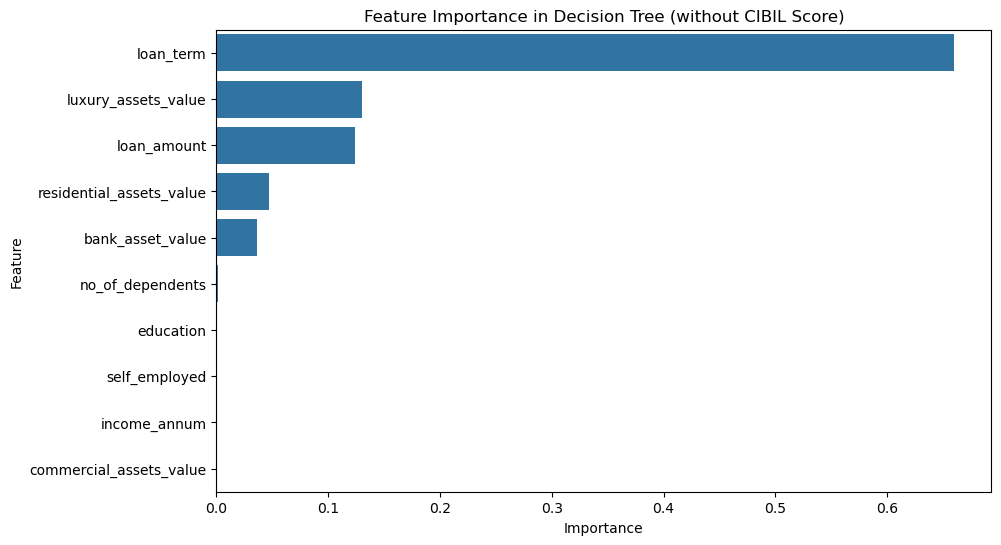

In [63]:
importances = dt_classifier.feature_importances_
features = X_no_cibil.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title("Feature Importance in Decision Tree (without CIBIL Score)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()